In [51]:
# This silences FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# We will use pandas to manipulate our data using DataFrames
import pandas as pd

# This reads the user data (.csv) as a DataFrame
df = pd.read_csv("/Users/suyashgoel/product-recommendation/shopping_behavior_updated.csv")

print("Reading customer data.")

Reading customer data.


In [52]:
# We will use matplotlib for data visualization to detect outliers (problematic for KMeans)
import matplotlib.pyplot as plt

# We will use seaborn for heatmaps meant to check for collinearity (problematic for KMeans)
import seaborn as sns

# Selects the features we believe may help predict good recommendations
selected_features_df = df[['Age', 'Gender', 'Location', 'Season',
                           'Subscription Status', 'Previous Purchases', 'Frequency of Purchases']]

print('Selecting our features as age, gender, location, season, subscription status, previous purchases, and frequency of pruchases.')


Selecting our features as age, gender, location, season, subscription status, previous purchases, and frequency of pruchases.


In [53]:
print("We will now visualize our numeric variables to identify potential outliers, since KMeans is sensitive to outliers.")

We will now visualize our numeric variables to identify potential outliers, since KMeans is sensitive to outliers.


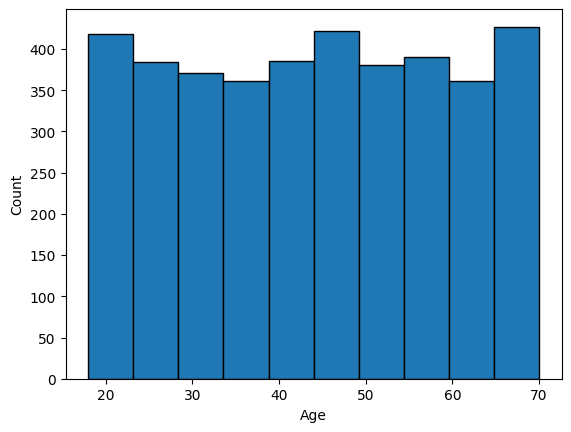

Age does not appear to contain any outliers. Therefore we can proceed.


In [54]:
# Plots a histogram to detect any ages that appear to be outliers
# There are no outliers

num_var = 'Age'

plt.hist(selected_features_df[num_var], bins=10, edgecolor='k', alpha=1.0)
plt.xlabel(num_var)
plt.ylabel('Count')
plt.show()

print(num_var, "does not appear to contain any outliers. Therefore we can proceed.")


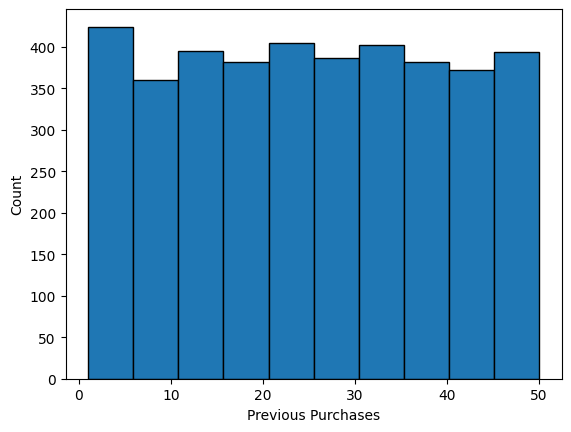

Previous Purchases does not appear to contain any outliers. Therefore we can proceed.


In [55]:
# Plots a histogram to detect any number of previous purchases that appear to be outliers 
# There are no outliers
num_var = 'Previous Purchases'

plt.hist(selected_features_df[num_var], bins=10, edgecolor='k', alpha=1.0)
plt.xlabel(num_var)
plt.ylabel('Count')
plt.show()

print(num_var, "does not appear to contain any outliers. Therefore we can proceed.")


In [56]:
print('We will now visualize correlation/association between variables since multicollinearity is problematic for KMeans, giving disproportionate weight to highly corrleated variables.')

We will now visualize correlation/association between variables since multicollinearity is problematic for KMeans, giving disproportionate weight to highly corrleated variables.


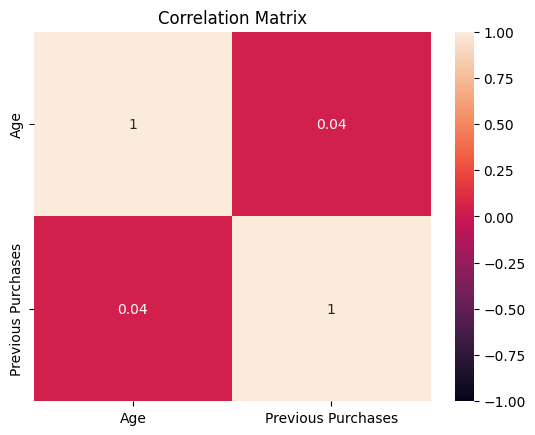

Since correlation between our numeric variables is relatively low, we can proceed.


In [57]:
# Makes a heat map to check for correlation between numeric variables
# Since we have low correlations, we can proceed
plt.figure()
sns.heatmap(selected_features_df.select_dtypes(include=['int', 'float']).corr(), vmin = -1, vmax = 1, annot= True)
plt.title('Correlation Matrix')
plt.show()

print('Since correlation between our numeric variables is relatively low, we can proceed.')

In [58]:
# We use these imports to help us compute cramer's v without rebuilding calculations such as square root and chi-square test, and easy matrix manipulation
from scipy.stats import chisquare, chi2_contingency
import math
import numpy as np

# Calculates Cramér's V (assocation) between our categorical variables
def cramers(df):
    num_cols = df.shape[1]
    cramer_matrix = np.zeros((num_cols, num_cols))
    for cat1 in range(num_cols):
        for cat2 in range(num_cols):
            ct = pd.crosstab(df[df.columns[cat1]], df[df.columns[cat2]])
            c, p, dof, expected = chi2_contingency(ct) 
            n = sum(np.sum(ct))
            k = min(ct.shape)
            cramer_matrix[cat1, cat2] = math.sqrt(c / (n * k))
    cramer_matrix = pd.DataFrame(cramer_matrix, columns=df.columns, index=df.columns)
    return cramer_matrix

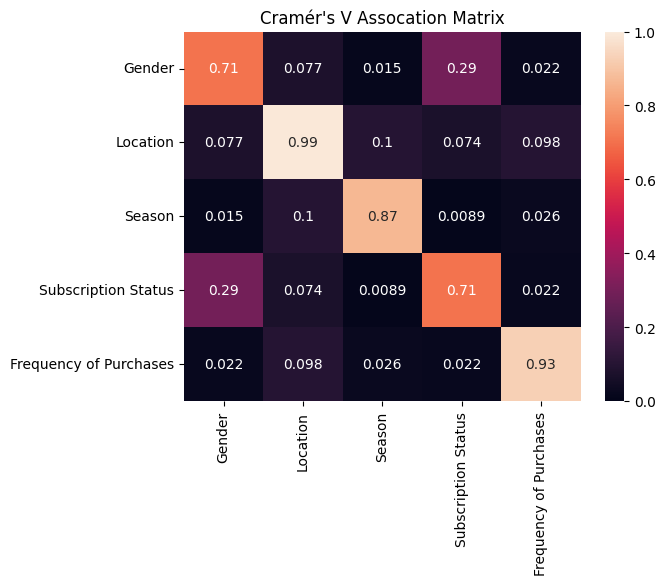

Cramér's V value measures association between categorical variables. Since values are relatively low between variables, we can proceed.


In [59]:
# Selects our categorical variables, or those of type 'object'
cat_var = selected_features_df.select_dtypes('object')

# Creates a heatmap indicating the level of association between categorical variables
# Since no variables are highly associated, we can proceed
sns.heatmap(cramers(cat_var), vmin = 0, vmax = 1, annot= True)
plt.title('Cramér\'s V Assocation Matrix')

plt.show()

print('Cramér\'s V value measures association between categorical variables. Since values are relatively low between variables, we can proceed.')


In [60]:
from sklearn.preprocessing import StandardScaler

# StandardScaler scales numeric variables so KMeans can work more efficiently
sc = StandardScaler()

# scaled_df has numeric variables
scaled_df = pd.concat([selected_features_df["Age"], selected_features_df["Previous Purchases"]], axis=1)

# Fit the standard scaler using our numeric variables
sc.fit(scaled_df)

# Apply a transformation to our numeric variables according to this model
scaled_df = sc.transform(scaled_df)

# Convert the transformed numeric data  into a DataFrame with the appropriate column names
scaled_df = pd.DataFrame(scaled_df, columns= ["Age", "Previous Purchases"])

# Append categorical variable columns to scaled_df 
scaled_df = pd.concat([scaled_df, selected_features_df['Gender'], selected_features_df['Location'], selected_features_df['Season'], selected_features_df['Subscription Status'], selected_features_df['Frequency of Purchases']], axis=1)

print('We use StandardScaler to scale our numeric variables so they are equally weighted')

We use StandardScaler to scale our numeric variables so they are equally weighted


In [61]:
# Create dummy variables for each categorical variable since KMeans only takes numeric data
# This means we create a feature for each categorical variable's value (dropping the first since we won't lose information). A 1 indicates that a customer has the dummy variable attribute, and a 0 means it doesn't have it.
# For example, we get a dummy variable Male, which will be 1 for customers with Gender == 'Male' and 0 for all other customers
gender = pd.get_dummies(selected_features_df['Gender'], drop_first=True, dtype=int)
loc = pd.get_dummies(selected_features_df['Location'], drop_first=True, dtype=int)
season = pd.get_dummies(selected_features_df['Season'], drop_first=True, dtype=int)
status = pd.get_dummies(selected_features_df['Subscription Status'], drop_first=True, dtype=int)
freq = pd.get_dummies(selected_features_df['Frequency of Purchases'], drop_first=True, dtype=int)

# Construct DataFrame for our encoded and scaled data, adding our dummy variables to the scaled data
encoded_and_scaled_df = scaled_df
encoded_and_scaled_df = pd.concat([scaled_df, gender, loc, season, status, freq], axis=1)

# Remove the original categorical variables
encoded_and_scaled_df.drop(columns=['Gender', 'Location', 'Season', 'Subscription Status', 'Frequency of Purchases'], inplace=True)

print('KMeans uses numeric variables, so we create dummy variables for categorical variables. This means we create binary columns for each category, with 1 indicating a customer being a part of a category. We replace these dummy variables without our original categorical variables.')

KMeans uses numeric variables, so we create dummy variables for categorical variables. This means we create binary columns for each category, with 1 indicating a customer being a part of a category. We replace these dummy variables without our original categorical variables.


In [62]:
# KMeans performs poorly and struggles to form good clusters with high dimensionality. We can use PCA to decrease our dimensionality
from sklearn.decomposition import PCA

# Define a PCA instance, intending to reduce dimensions until our principal components stop explaining 80% of our variance
pca = PCA(0.8)
pca.fit(encoded_and_scaled_df)


# Apply the PCA transformation, and make a DataFrame we will pass into KMeans.
pca_df = pd.DataFrame(pca.transform(encoded_and_scaled_df))

print("KMeans struggles to perform optimal clustering with high dimensionality, or the presence of many variables. Therefore, we can use PCA, Principal Component Analysis, to reduce our dimensions with minimal data loss.")
print("We specify n_components=3, indicating we want our data to be 3-dimensional")


KMeans struggles to perform optimal clustering with high dimensionality, or the presence of many variables. Therefore, we can use PCA, Principal Component Analysis, to reduce our dimensions with minimal data loss.
We specify n_components=3, indicating we want our data to be 3-dimensional


In [63]:
pca_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.041575,1.025800,0.731058,-0.558302,-0.692505,-0.125802,-0.171750,-0.212898,0.700473,-0.431489,-0.366678,-0.183271,-0.034242,-0.010152
1,2.301602,-0.065500,0.761871,-0.527567,-0.680543,-0.131247,-0.144381,-0.182320,0.721618,-0.400969,-0.356280,-0.181681,-0.030962,-0.012531
2,-0.185943,0.399477,0.744902,0.781778,-0.195099,-0.108639,-0.269481,-0.216559,0.146806,0.848640,-0.197582,-0.155075,-0.022116,-0.029995
3,-0.120892,-2.220085,0.687756,0.841739,-0.175356,-0.100168,-0.281654,-0.213130,0.146613,0.862371,-0.213233,-0.140508,-0.018542,-0.022721
4,-0.340618,-0.228713,0.710203,0.801172,-0.161538,0.013523,-0.069696,-0.013300,-0.020526,0.021236,-0.310410,-0.140867,0.024272,0.029406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,-0.124497,-0.497089,-0.647198,-0.286041,0.774142,-0.145202,-0.281035,-0.241496,0.181395,0.881826,-0.115606,-0.170027,-0.035572,-0.021842
3896,-1.111234,-0.368327,-0.738951,0.825456,-0.100507,-0.154691,-0.245949,-0.575066,-0.557630,-0.281023,-0.197401,-0.122400,-0.027067,-0.014713
3897,-0.026501,0.182105,-0.687465,0.804885,-0.064926,-0.319054,0.771739,0.164480,-0.064249,0.056678,-0.399637,-0.172048,-0.032838,-0.011550
3898,0.076714,0.080459,-0.632561,-0.290108,0.767161,-0.134749,-0.291132,-0.227770,0.189852,0.875361,-0.112149,-0.141514,-0.069353,-0.080095


In [64]:
print('We use KMeans from scikit-learn for clustering, which requires a specified number of clusters. We specify hyperparameter init = \'k-means++\', which optimizes initial cluster centroid selection.')


We use KMeans from scikit-learn for clustering, which requires a specified number of clusters. We specify hyperparameter init = 'k-means++', which optimizes initial cluster centroid selection.


In [65]:
# This allows us to use the KMeans algorithm provided by scikit-learn
from sklearn.cluster import KMeans

# Define the number of clusters using user input
num_clusters = int(input('Enter the number of clusters you want to segment users into based on their demographics. This must be more than the number of recommendations you want.'))

# Initialize a KMenas instance with num_clusters clusters, and we use init = 'k-means++', which means we begin with better centroid initialization
kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++')

# Fit KMeans using the 3-dimension DataFrame
kmeans.fit(pca_df)

# Predict the clusters customers are a part of
labels = kmeans.predict(pca_df)

# Add a column to our original DataFrame with each customer's cluster value
df["Clusters"] = labels

print('We then store the cluster each customer is in using a new column our original DataFrame')

We then store the cluster each customer is in using a new column our original DataFrame


In [66]:
print("Now we can make predictions on a new user, allowing us to make product recommendations based on the preferences of similar users.")

Now we can make predictions on a new user, allowing us to make product recommendations based on the preferences of similar users.


In [67]:
# Take user input to generate a customer we want to create recommendations for
age = int(input('Enter the age of an existing customer you want recommendations for'))
gender = input('Enter the gender of the customer')
location = input('Enter the US State the customer resides in')
season = input('Enter the season the customer is making a purchase during')
subscription_status = input('Provide the subscription status of the user')
previous_purchases = int(input('Enter the number of purchases the customer the customer has made'))
frequency_of_purchases = input('Enter the frequency at which the customer makes purchases')

# Make an array with the user-inputted values
row = [age, gender, location, season, subscription_status, previous_purchases, frequency_of_purchases]

# Make a DataFrame using our inputted values corresponding to each column of updated_df, and we set our column values to be those of updated_df (same order)
sample = pd.DataFrame([row], columns=['Age','Gender', 'Location', 'Season', 'Subscription Status', 'Previous Purchases', 'Frequency of Purchases'])

print('We construct a DataFrame in the format of the DataFrame with our selected features.')

We construct a DataFrame in the format of the DataFrame with our selected features.


In [68]:
# Scale numeric features for the new customer using the previous StandardScaler instance we fitted (using the same model)
scaled_sample = pd.DataFrame(sc.transform(sample[['Age', 'Previous Purchases']]), columns=['Age', 'Previous Purchases'])
# Add categorical variables to the scaled data
scaled_sample = pd.concat([scaled_sample, sample['Gender'], sample['Location'], sample['Season'],
                          sample['Subscription Status'], sample['Frequency of Purchases']], axis=1)

print('We transform the customer\'s numeric data using the previously fitted StandardScaler object.')

We transform the customer's numeric data using the previously fitted StandardScaler object.


In [69]:
# Gets a list of our original encoded and scaled DataFrame columns, ignoring the first two since we already have Age and Previous Purchases
bin_cols = list(encoded_and_scaled_df.columns)
bin_cols = bin_cols[2:len(bin_cols)]

# Copy our scaled sample onto a new DataFrame to include dummy variables
encoded_and_scaled_sample = scaled_sample

# Iterate through the columns, adding dummy variables to encoded_and_scaled_sample
# If there is a match in a dummy variable name and one of the customer's categorical labels, label the dummy variable with 1. Otherwise, label it 0
for col in bin_cols:
    if encoded_and_scaled_sample['Gender'][0] in col or encoded_and_scaled_sample['Location'][0] in col or encoded_and_scaled_sample['Season'][0] in col or encoded_and_scaled_sample['Subscription Status'][0] in col or encoded_and_scaled_sample['Frequency of Purchases'][0] in col:
        new_col = pd.DataFrame([1], columns=[col])
    else:
        new_col = pd.DataFrame([0], columns=[col])
    encoded_and_scaled_sample = pd.concat(
        [encoded_and_scaled_sample, new_col], axis=1)

# Drop the original categorical variables since we have encoded categorical variables 
encoded_and_scaled_sample.drop(columns=[
                               'Gender', 'Location', 'Season', 'Subscription Status', 'Frequency of Purchases'], inplace=True)

print('We add the binary columns from our encoded and scaled DataFrame for the customer, setting values to 1 or 0 depending on if the customer is part of a category or not.')
print('We then drop the original categorical variables.')


We add the binary columns from our encoded and scaled DataFrame for the customer, setting values to 1 or 0 depending on if the customer is part of a category or not.
We then drop the original categorical variables.


In [71]:
# Transforms the encoded and scaled sample using our previously fitted PCA instance (for dimensality reduction), and converts this into a DataFrame
pca_sample = pd.DataFrame(pca.transform(
    encoded_and_scaled_sample))

print('Using the PCA model we fitted for our dataset, we can transform the customer\'s scaled and encoded variables to fit the format of the data we used for our KMeans model.')

Using the PCA model we fitted for our dataset, we can transform the customer's scaled and encoded variables to fit the format of the data we used for our KMeans model.


In [72]:
# Makes a prediction of the 3-dimension sample using the fitted KMeans, and retrieves the cluster value
[cluster] = kmeans.predict(pca_sample)

print('We retrieve the cluster the customer is in by making a prediction, and we store this so we can access similar customers.')

We retrieve the cluster the customer is in by making a prediction, and we store this so we can access similar customers.


In [73]:
# Saves customers in the same cluster
similar_customers = df.loc[df["Clusters"] == cluster]

# Reduces potential recommendations to those with at least 3/5 star reviews for the products similar customers bought
potential_recommendations = similar_customers[similar_customers['Review Rating'] >= 3]

print('We then retrieve customers in the same cluster and store similar customers that purchased products, and gave the products at least a 3/5 rating, to generate potential recommendations.')

We then retrieve customers in the same cluster and store similar customers that purchased products, and gave the products at least a 3/5 rating, to generate potential recommendations.


In [74]:
# Retrieves counts for the potential recommendations
items = potential_recommendations['Item Purchased'].value_counts()

print('We then make a list of potential recommendations by listing potential recommendations in order of decreasing frequency.')

We then make a list of potential recommendations by listing potential recommendations in order of decreasing frequency.


In [75]:
# Takes user input to determine the number of product recommendations and prints them
num_recs = int(input('Enter the number of recommendations you want for the customer'))
print("Here are the top", num_recs, "recommendations for this customer based on what similar customers have been satisifed with!")

# Prints the [num_recs] products with the highest frequencies in items
for i in range(num_recs):
    print(items.index[i])

Here are the top 5 recommendations for this customer based on what similar customers have been satisifed with!
Shorts
Socks
Belt
T-shirt
Sneakers


In [76]:
# Creates a Colors column for visualization, labeling customers in the same cluster as the customer we made predictions on as orange, and all others as blue
for index in df.index:
    if df.loc[index, 'Clusters'] == cluster:
        df.loc[index, 'Colors'] = 'orange'
    else:
        df.loc[index, 'Colors'] = 'blue'
    
print('We have created a column to store the colors we want to plot each customer as (based on the cluster they are in).')

We have created a column to store the colors we want to plot each customer as (based on the cluster they are in).


In [77]:
print('We can visualize relationships between variables on a scatterplot to help visualize our clusters with meaning.')
print('Let\'s plot our numeric variables, age and previous purchases.')

We can visualize relationships between variables on a scatterplot to help visualize our clusters with meaning.
Let's plot our numeric variables, age and previous purchases.


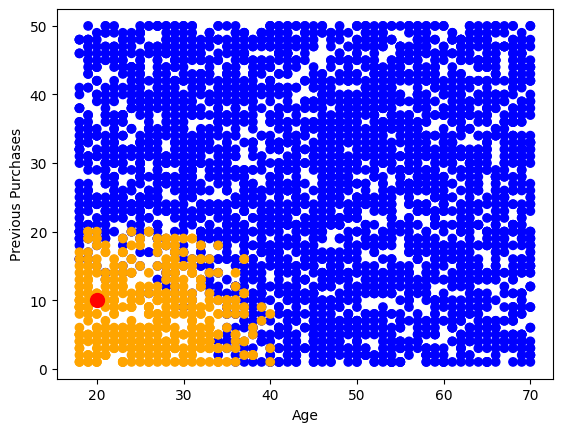

We plot Age and Previous Purchases with the red point being the customer we made predictions on, the orange points being customers in the same cluster, and blue points being all other customers.


In [78]:
# Gets user input to plot two variables against each other for the customers to visualize relationships within the cluster and out of it
feature_one = 'Age'
feature_two = 'Previous Purchases'

non_similar_customers = df[df['Colors'] == 'blue']
similar_customers = df[df['Colors'] == 'orange']

# Plots the customer data for these features, using the colors we specify in df['Colors']
plt.scatter(non_similar_customers[feature_one],
            non_similar_customers[feature_two], c=non_similar_customers['Colors'])

plt.scatter(similar_customers[feature_one],
            similar_customers[feature_two], c=similar_customers['Colors'])

# Retrieves the new customer's labels for these features
sample_feature_one = sample['Age']
sample_feature_two = sample['Previous Purchases']

# Plots the new customer's data in a larger size with a red color
plt.scatter(sample_feature_one, sample_feature_two, c='red', s=100)

# Labels the plots with the feature names
plt.xlabel(feature_one)
plt.ylabel(feature_two)

# Shows the scatterplot
plt.show()

print('We plot', feature_one, 'and', feature_two, 'with the red point being the customer we made predictions on, the orange points being customers in the same cluster, and blue points being all other customers.')